In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from random import choice, randint

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
 # size of the query
n = 3

circuit = QuantumCircuit(n+1, n+1) # add one auxiliary qubit

# Place all query qubits in a superposition state
for qbit in range(n):
    circuit.h(qbit)

# Flip auxiliary, then put it in superposition for phase kickback
circuit.x(n)
circuit.h(n)
circuit.barrier()

In [3]:
# define the function (called Oracle)
def Oracle(circuit, n):
    '''Output: the oracle function (balanced, constant=0 or constant=1)'''
    oracle_type = choice(['Balanced', 'Constant0', 'Constant1']) # random choice of oracle
    
    if oracle_type == 'Balanced':
        # we randomly flip query qubits to ensure the U_f is a black box
        flipGates = randint(0, 2**n-1) # we have n qubits, thus 2**n possible configurations
        flipGates = format(flipGates, '0' + str(n) + 'b') # format to binary
        # flip the randomly chosen qubits:
        for qbit in range(0, len(flipGates)):
            if flipGates[qbit] == '1':
                circuit.x(qbit)
        
        # apply CNOT to the auxiliary (this is where we apply the oracle)        
        for qbit in range(0, n):
            circuit.cx(qbit, n+1) 
        
        # unflip the qubits
        for qbit in range(0, len(flipGates)):
            if flipGates[qbit] == '1':
                circuit.x(qbit)
                
    elif oracle_type == 'Constant0':
        # flip the auxiliary
        circuit.z(n) 
    
    elif oracle_type == 'Constant1':
        pass
    
    circuit.barrier()
    return circuit, oracle_type # output oracle_type to check if our algorithm works

In [4]:
circuit, oracle_type = Oracle(circuit, n)

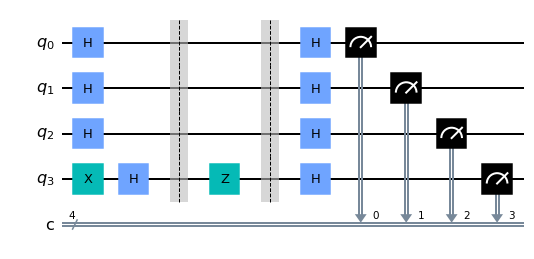

In [5]:
for qbit in range(n+1):
    circuit.h(qbit) # revert H transform on query and target
    circuit.measure(qbit, qbit) # measure each qubit
circuit.draw()

In [6]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shoats=1, memory=True)
result = job.result()
measurements = result.get_memory()[0]

In [7]:
query_state = measurements[-1] # this is the measurement of the first qubit
print('Prediction:')
if query_state == '1':
    print('Balanced')
else:
    aux_output = measurements[0] # measurement of the auxiliary
    if aux_output == '1':
        print('Constant 1')
    else:
        print('Constant 0')
        
print('True Oracle:')
print(oracle_type)

Prediction:
Constant 0
True Oracle:
Constant0
